# Sparse Data and Null Handling

## Overview

This notebook provides an overview of applying Howso Engine to sparse data (i.e., data that contain missing values) and helps to characterize how prediction performance is affected as model sparsity increases.  Howso Engine does not require any preprocessing to handle nulls or NaNs, but has notable robustness when it comes to working with data that contain them.

We demonstrate that the Howso Engine can maintain accuracy even when the training data has increasing proportions of missing values. This makes the Howso Engine a great option for use-cases with sparse datasets. Additionally, the Howso Engine has the ability to treat missing values semantically. This unlocks the ability for the Engine to find trends in the data relating to missing values for each feature, which could reveal powerful insights for users.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmlb

from howso.engine import Trainee
from howso.utilities import infer_feature_attributes

## Step 1: Load Data

We use the ``breast_w`` dataset from the [PMLB](https://github.com/EpistasisLab/pmlb).

In [2]:
df = pmlb.fetch_data("breast_w", local_cache_dir="../../data/breast_w")

df

,Clump_Thickness,Cell_Size_Uniformity,Cell_Shape_Uniformity,Marginal_Adhesion,Single_Epi_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,target
0,5.0,1.0,1.0,1.0,2.0,0,3.0,1.0,1.0,0
1,5.0,4.0,4.0,5.0,7.0,1,3.0,2.0,1.0,0
2,3.0,1.0,1.0,1.0,2.0,2,3.0,1.0,1.0,0
3,6.0,8.0,8.0,1.0,3.0,4,3.0,7.0,1.0,0
4,4.0,1.0,1.0,3.0,2.0,0,3.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...
694,3.0,1.0,1.0,1.0,3.0,2,1.0,1.0,1.0,0
695,2.0,1.0,1.0,1.0,2.0,0,1.0,1.0,1.0,0
696,5.0,10.0,10.0,3.0,7.0,3,8.0,10.0,2.0,1
697,4.0,8.0,6.0,4.0,3.0,4,10.0,6.0,1.0,1


Since the datasets in the PMLB have been cleaned, they don't contain many missing values. We add nulls into 20% of the dataset here.

In [3]:
null_percent = 0.2
rng = np.random.default_rng()

def insert_percent_nulls(data: pd.DataFrame, percent: float) -> pd.DataFrame:
    data = data.copy(deep=True)
    mask = rng.uniform(size=data.shape) < percent
    data[mask] = None

    return data

null_df = insert_percent_nulls(df, null_percent)
null_df

,Clump_Thickness,Cell_Size_Uniformity,Cell_Shape_Uniformity,Marginal_Adhesion,Single_Epi_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,target
0,5.0,1.0,1.0,1.0,2.0,NaN,3.0,1.0,1.0,0.0
1,5.0,4.0,4.0,5.0,7.0,1.0,3.0,2.0,1.0,0.0
2,3.0,NaN,1.0,NaN,2.0,2.0,3.0,1.0,1.0,0.0
3,6.0,8.0,8.0,1.0,3.0,NaN,NaN,NaN,1.0,0.0
4,4.0,1.0,1.0,3.0,2.0,0.0,3.0,NaN,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
694,NaN,NaN,NaN,1.0,3.0,2.0,1.0,NaN,NaN,0.0
695,2.0,1.0,1.0,NaN,2.0,0.0,1.0,1.0,1.0,0.0
696,5.0,10.0,10.0,3.0,7.0,3.0,8.0,10.0,2.0,1.0
697,4.0,NaN,NaN,4.0,3.0,4.0,10.0,NaN,NaN,1.0


## Step 2: Define the Feature Attributes

The Howso Engine always requires a set of defined feature attributes. We recommend using `infer_feature_attributes` as do most of the work quickly, but we always recommend manual inspection of these resulting feature attributes.

In [4]:
features = infer_feature_attributes(null_df)
features

{'Clump_Thickness': {'type': 'continuous',
  'data_type': 'number',
  'decimal_places': 0,
  'original_type': {'data_type': 'numeric', 'size': 8},
  'bounds': {'min': 1.0, 'max': 20.0, 'allow_null': True}},
 'Cell_Size_Uniformity': {'type': 'continuous',
  'data_type': 'number',
  'decimal_places': 0,
  'original_type': {'data_type': 'numeric', 'size': 8},
  'bounds': {'min': 1.0, 'max': 20.0, 'allow_null': True}},
 'Cell_Shape_Uniformity': {'type': 'continuous',
  'data_type': 'number',
  'decimal_places': 0,
  'original_type': {'data_type': 'numeric', 'size': 8},
  'bounds': {'min': 1.0, 'max': 20.0, 'allow_null': True}},
 'Marginal_Adhesion': {'type': 'continuous',
  'data_type': 'number',
  'decimal_places': 0,
  'original_type': {'data_type': 'numeric', 'size': 8},
  'bounds': {'min': 1.0, 'max': 20.0, 'allow_null': True}},
 'Single_Epi_Cell_Size': {'type': 'continuous',
  'data_type': 'number',
  'decimal_places': 0,
  'original_type': {'data_type': 'numeric', 'size': 8},
  'boun

## Step 3: Train and Analyze Data

We then train the data into a `Trainee` and analyze the data to determine the best hyperparameters.  Note that we are explicitly declaring our default context and action features.

In [5]:
action_features = ["target"]
context_features = features.get_names(without=action_features)

t = Trainee(features=features, default_action_features=action_features, default_context_features=context_features)
t.train(null_df)
t.analyze(context_features=context_features, action_features=action_features)

## Step 4: Measure Trainee Accuracy

Finally, we get the prediction stats.  The default action feature, `target`, is categorical so we are concerned with *precision*,  *recall*, and *accuracy*.

Here, we specifically compute `residuals_robust`. This computes what we call "Robust Residuals" which is to compute the mean absolute error of predictions on every feature where the context features are sampled over the power set of all other features. These residuals should typically be larger than the more typical "Full Residuals" which are computed as the mean absolute error of predictions on each feature where **every** other feature is used as a context.

In [6]:
t.react_into_trainee(action_feature=action_features[0], residuals_robust=True)
t.get_prediction_stats(stats=["accuracy", "precision", "recall"])[action_features]

,target
precision,0.912752
accuracy,0.924298
recall,0.920938


In [7]:
t.delete()

## Step 5: Evaluate Performance at Multiple Sparsity Levels

Now we evaluate the `Trainee` performance at multiple sparsity levels to characterize how prediction performance holds up in the presence of many nulls.

To do this, we simply create versions of the dataset with different proportions of null values, and do the same accuracy evaluation we demonstrated above.

In [8]:
null_percentages = np.linspace(0, 0.9, num=10)
prediction_stats_list = []

for null_percent in null_percentages:
    print(f"Evaluating Trainee for {round(null_percent * 100)}% nulls")

    # Create a DataFrame that is a copy of the input DataFrame that has the correct percentage of null values.
    null_df = insert_percent_nulls(df, null_percent)
    # Infer feature attrbiutes for the new DataFrame
    null_features = infer_feature_attributes(null_df)
    # Create the Trainee, train, and analyze
    t = Trainee(features=null_features, default_action_features=action_features, default_context_features=context_features)
    t.train(null_df)
    t.analyze(context_features=context_features, action_features=action_features)
    # Compute, fetch, and store the prediction stats
    t.react_into_trainee(action_feature=action_features[0], residuals_robust=True)
    prediction_stats = t.get_prediction_stats(stats=["accuracy", "precision", "recall"])[action_features]
    prediction_stats_list.append(prediction_stats.T)
    # Clean up the Trainee
    t.delete()

Evaluating Trainee for 0% nulls


Evaluating Trainee for 10% nulls


Evaluating Trainee for 20% nulls


Evaluating Trainee for 30% nulls


Evaluating Trainee for 40% nulls


Evaluating Trainee for 50% nulls


Evaluating Trainee for 60% nulls


Evaluating Trainee for 70% nulls


Evaluating Trainee for 80% nulls


Evaluating Trainee for 90% nulls


In [9]:
prediction_stats_df = pd.concat(prediction_stats_list, ignore_index=True).set_index(pd.Index(null_percentages, name="Null %"))
prediction_stats_df

,precision,accuracy,recall
Null %,,,
0.0,0.948921,0.950254,0.940458
0.1,0.934748,0.940199,0.930364
0.2,0.899239,0.923261,0.911826
0.3,0.914141,0.922018,0.913272
0.4,0.868571,0.888889,0.884869
0.5,0.818002,0.833656,0.812875
0.6,0.804898,0.817967,0.809995
0.7,0.796977,0.800000,0.794744
0.8,0.604664,0.621212,0.592208


As we can see, Howso Engine performs quite well even when significant fractions of the dataset are replaced with null values.

Text(0.5, 1.0, 'Prediction Stats for Different Levels of Sparsity')

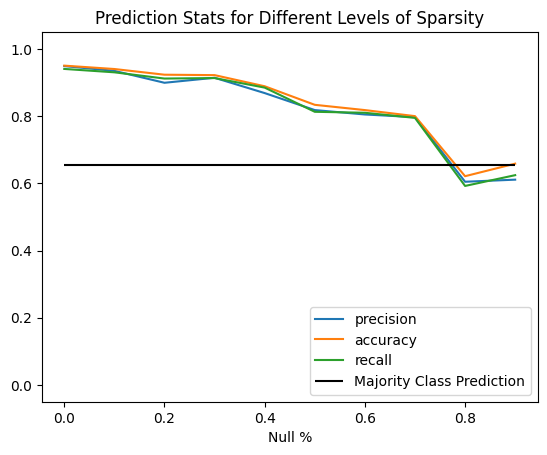

In [10]:
majority_class_accuracy = df.target.value_counts(normalize=True).max()

ax = prediction_stats_df.plot()
ax.set_ylim(-0.05, 1.05)
ax.hlines(y=majority_class_accuracy, xmin=0, xmax=0.9, color="black", label="Majority Class Prediction")
ax.legend(loc="lower right")
ax.set_title("Prediction Stats for Different Levels of Sparsity")

# Conclusion

In this notebook we demonstrate the ability of the Howso Engine to natively handle data with missing values. Furthermore we demonstrate that the Howso Engine can maintain accuracy even when the training data has increasing proportions of missing values. This makes the Howso Engine a great tool to use in use-cases where datasets have many missing values (even when the missing values themselves are informative!).